# **GCN ( Graph convolutional networks )**

# **Define The problem**

-> Predict the anticancer activity of a chemical compound . The chemical compound can be positive or negative against lung cancer cell and  labelled as either 0 ( Negiative ) or 1( positive ).

#**1 - What is the input?**
--------------------------------
-> File of Extension PDF contains (25024, 3) example

* Part 1 of Label to classify to -1 or 1 .
* Part 2 type of Node ( S,O,N,C,...... ETC)
* Part 3 From and To of graph using the labels  




#**2 - What is the output?**
-> Classify The Inputs Graph to Y-Label Drug Prediction (1, 0)

-> Classify The chemical compound can be positive or negative against lung cancer cell and thus labelled ( 0 Or 1 ).


#**3 - What data mining function is required?**
-> clean our input data to get the desired knowledge

-> Data mining generally refers to examining a large amount of data to extract valuable information. The data mining process uses predictive models based on existing and historical data to project potential outcome for business activities and transactions.


#**4 - What could be the challenges?**
-> Interact with Graph cnn as new topic .

-> Plot the graph that show us the connections between nodes .

-> Interact with text using nlp

-> Tunning multiple parameters

-> Apply more than 10 trials


#**5 - What is the impact?**

 It is a binary classification problem based on the graph data. The task is to predict the anticancer activity of a chemical compound. The chemical compound can be positive or negative against lung cancer cell and thus labelled ( 0 Or 1 ).

#**6 - What is an ideal solution?**

Trial 10 

 Using 32 For hidden Units using OverSampling Method with  message_passing mechanisms (GGNN)

# **Methods I Used**

1-  R-GCN Method

2- GGNN Method

3- R-GIN Method

4- Upsampling

5- Tokenizer

In [1]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 73 kB 1.9 MB/s 
     |████████████████████████████████| 134 kB 61.7 MB/s 
     |████████████████████████████████| 346 kB 55.6 MB/s 
     |████████████████████████████████| 1.2 MB 52.1 MB/s 
     |████████████████████████████████| 462 kB 75.6 MB/s 
     |████████████████████████████████| 178 kB 74.9 MB/s 
     |████████████████████████████████| 79 kB 8.7 MB/s 
     |████████████████████████████████| 3.6 MB 50.4 MB/s 
     |████████████████████████████████| 85 kB 4.4 MB/s 
     |████████████████████████████████| 41 kB 756 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.


In [2]:
# Import All Library 

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split # import split function 
from tf2_gnn.layers.gnn import GNN, GNNInput
from tensorflow.keras.preprocessing.text import Tokenizer # Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import pandas as pd 
import math
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler

# Here we define instulation of kaggle 

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c cisc873-dm-f22-a6

  0% 0.00/3.86M [00:00<?, ?B/s]
100% 3.86M/3.86M [00:00<00:00, 183MB/s]


In [ ]:
! unzip /content/cisc873-dm-f22-a6.zip # extract the files 

Archive:  /content/cisc873-dm-f22-a6.zip
  inflating: gcnn-template.ipynb     
  inflating: test_x.sdf              
  inflating: train.sdf               


## Read SDF format data (structured-data format)

In [ ]:
'''

                 < read_sdf>

       This function for read and format ( SDF ) file .

'''

def read_sdf(file):
   # extract data from sdf file 
    with open(file, 'r') as rf:
        content = rf.read() # read file of sdf extention
    samples = content.split('$$$$') # split on $ sign of each sample (Read sample by sample )
    
    def parse_sample(s):
        lines = s.splitlines() # Split each lines 
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':  # search for 1 label 
                label = 1
            if l.strip() == '-1.0': # search for -1 label 
                label = 0
            if l.startswith('    '):
                feature = l.split() # split on white space
                node = feature[3] # node extraction  s , o , n atoms
                nodes.append(node) # append into list 
            elif l.startswith(' '): # search for one space
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                
        
        

In [ ]:
training_set = read_sdf('train.sdf') # Read sdf file (Training)
print(np.array(training_set).shape)
training_set, validation_set = train_test_split(training_set, test_size=0.15,) # Split training data into training and validation 


  0%|          | 0/25024 [00:00<?, ?it/s]

(25024, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
testing_set  = read_sdf('test_x.sdf') # Read test sdf file 

  0%|          | 0/12326 [00:00<?, ?it/s]

In [ ]:
print(training_set[1])

(['Cl', 'O', 'N', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0, 17],
       [ 1, 14],
       [ 1, 24],
       [ 2,  7],
       [ 2, 10],
       [ 3,  7],
       [ 3, 13],
       [ 4,  8],
       [ 4, 13],
       [ 5,  8],
       [ 6,  7],
       [ 6,  8],
       [ 6,  9],
       [ 9, 12],
       [10, 15],
       [10, 16],
       [11, 12],
       [11, 14],
       [11, 18],
       [14, 20],
       [15, 17],
       [16, 19],
       [17, 21],
       [18, 22],
       [19, 21],
       [20, 23],
       [22, 23]]), 0)


## Visualizing/Inspecting a Sample

In [ ]:
!pip install --quiet networkx
colors = cm.rainbow(np.linspace(0, 1, 50)) # Colors 

In [ ]:
'''
  Visualization Method

'''
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

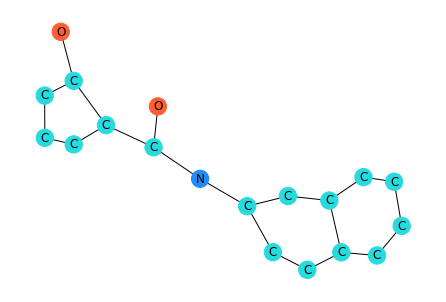

In [ ]:
plt.clf()
visualize(training_set[20]) # Visulization Of Graph 

## Preprocessing:

In [ ]:
max_vocab = 500 # Max Vocab
max_len = 100 # Max Length 


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # All Nodes 
tokenizer = Tokenizer(num_words=max_vocab) # Tokenizer  
tokenizer.fit_on_texts(all_nodes) #this method creates the vocabulary index based on word frequency.
#all_nodes
#print(all_nodes)
#print(tokenizer.word_index)

In [ ]:
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post') # padding each one 
    '''
       texts_to_sequences -> Transforms each text in texts to a sequence of integers. 
    So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
    Nothing more, nothing less, certainly no magic involved
    '''
    max_nodes_len = np.shape(sample_nodes)[1] # number of nodes in each sample
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0] # make sure all nodes are non zero
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)    # Concatenate nodes of all samples together
    all_edges = np.concatenate(edges)  # Concatenate edges of all samples together

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
print(training_set[0])
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

(['Cl', 'O', 'O', 'O', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0, 15],
       [ 1,  8],
       [ 1, 16],
       [ 2,  8],
       [ 3, 14],
       [ 5,  4],
       [ 4, 14],
       [ 5,  7],
       [ 5,  8],
       [ 6,  7],
       [ 6,  9],
       [ 6, 10],
       [ 9, 12],
       [10, 13],
       [11, 12],
       [11, 13],
       [11, 15],
       [14, 17],
       [16, 18]]), 0)
data
[2 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 2
 2 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 2 2
 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
edges
[[  0   2]
 [  1   2]
 [  2   3]
 [  3   4]
 [  4   5]
 [  5   6]
 [  6   7]
 [  7   8]
 [  8   9]
 [ 46  36]
 [ 36  60]
 [ 37  60]
 [ 38  63]
 [ 38  64]
 [ 49  39]
 [ 39  61]
 [ 39  62]
 [ 58  40]
 [ 40  65]
 [ 40  66]
 [ 41  42]
 [ 41  44]
 [ 41  47]
 [ 42  43]
 [ 42

In [ ]:
def GCNN(hidden_dim,message_calculation_class="",num_heads=1):
  
  data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
  edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
  node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
  embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
  num_graph = tf.reduce_max(node2graph)+1

  gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
  params = GNN.get_default_hyperparameters()
  
  params["hidden_dim"] = hidden_dim
  if (len(message_calculation_class)>0):
     params["message_calculation_class"] = message_calculation_class
  if(message_calculation_class=="RGAT") :
     params["num_heads"]=num_heads

  gnn_layer = GNN(params)
  gnn_out = gnn_layer(gnn_input)

  print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
  avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
  print('mean:', avg)

  pred = Dense(1, activation='sigmoid')(avg)
  print('pred:', pred)

  model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
  model.summary()
  return model

# **Trial 1 -> Using 32 For hidden Units**

In [ ]:
model=GCNN(32) # call Function of model Gcnn using 32 hidden units .
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # EarlyStopping callbacks

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history1=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=100,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
     callbacks=[callback]
) # here we fit model 
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)# predict results 
y_pred = np.reshape(y_pred, -1)

# Sample Submission CSV
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission.csv') # save results in csv file 

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

1330/1330 [==============================] - 30s 20ms/step - loss: 0.2231 - auc: 0.5090 - val_loss: 0.1998 - val_auc: 0.5568
Epoch 2/100
1330/1330 [==============================] - 27s 20ms/step - loss: 0.2001 - auc: 0.6092 - val_loss: 0.2025 - val_auc: 0.6372
Epoch 3/100
1330/1330 [==============================] - 27s 21ms/step - loss: 0.1932 - auc: 0.6564 - val_loss: 0.1951 - val_auc: 0.6789
Epoch 4/100
1330/1330 [==============================] - 28s 21ms/step - loss: 0.1892 - auc: 0.6714 - val_loss: 0.1896 - val_auc: 0.6944
Epoch 5/100
1330/1330 [==============================] - 27s 21ms/step - loss: 0.1863 - auc: 0.6859 - val_loss: 0.1858 - val_auc: 0.6858
Epoch 6/100
1330/1330 [==============================] - 27s 20ms/step - loss: 0.1853 - auc: 0.6843 - val_loss: 0.1848 - val_auc: 0.7037
Epoch 7/100
1330/1330 [==============================] - 27s 20ms/step - loss: 0.1855 - auc: 0.6848 - val_loss: 0.1864 - val_auc: 0.6887
Epoch 8/100
1330/1330 [==============================

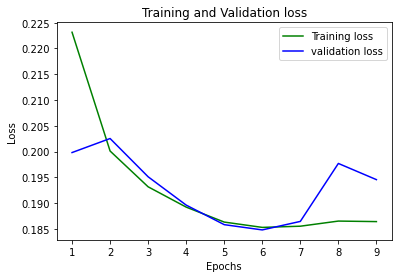

In [ ]:
'''
Visualize loss , val_loss vs number of epochs

'''
loss_train = history1.history['loss']
loss_val = history1.history['val_loss']
epochs = len(loss_train)+1 
plt.plot(np.arange(1,epochs), loss_train, 'g', label='Training loss')
plt.plot(np.arange(1,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

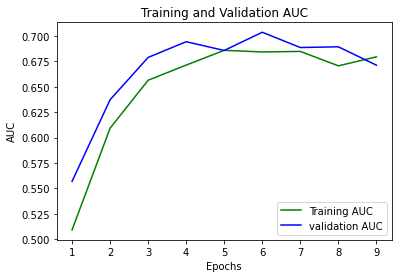

In [ ]:

'''
Visualize auc , val_auc vs number of epochs

'''
AUC_train = history1.history['auc']
AUC_val = history1.history['val_auc']
epochs = len(AUC_train)+1 # get the number of epochs for visulization 
plt.plot(np.arange(1,epochs), AUC_train, 'g', label='Training AUC')
plt.plot(np.arange(1,epochs), AUC_val, 'b', label='validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# We got from this trial 1 when hidden units = 32 
- loss: 0.1864 
- auc: 0.6795 
- val_loss: 0.1945 
- val_auc: 0.6713
 - According to graphs there is no overfitting happened and there is generalization here happend
 - On kaggle we got Score: 0.65423 %

# **Trial 2 -> Using 64 For hidden Units**

In [ ]:
model=GCNN(64) # calling the method within 64 hidden units

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)# complie 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # Using callbacks 
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history2=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=100,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[callback] # callbacks 
)
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
) # predict
y_pred = np.reshape(y_pred, -1)

# Sample Submission CSV
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_Hidden_64.csv')# Save results 

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

1330/1330 [==============================] - 32s 22ms/step - loss: 0.2197 - auc: 0.5280 - val_loss: 0.1878 - val_auc: 0.6768
Epoch 2/100
1330/1330 [==============================] - 28s 21ms/step - loss: 0.1942 - auc: 0.6379 - val_loss: 0.2157 - val_auc: 0.6445
Epoch 3/100
1330/1330 [==============================] - 27s 21ms/step - loss: 0.1900 - auc: 0.6730 - val_loss: 0.1940 - val_auc: 0.6859
Epoch 4/100
1330/1330 [==============================] - 27s 20ms/step - loss: 0.1917 - auc: 0.6630 - val_loss: 0.2087 - val_auc: 0.6488


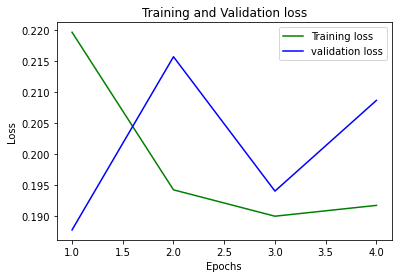

In [ ]:
'''
Visualize loss vs val_loss

'''
loss_train = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = len(loss_train)+1
plt.plot(np.arange(1,epochs), loss_train, 'g', label='Training loss')
plt.plot(np.arange(1,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

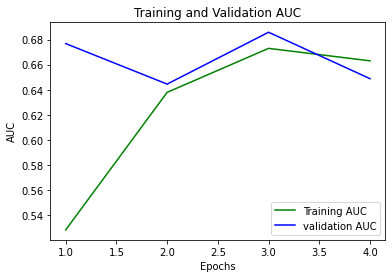

In [ ]:
'''
Visualize auc , val_auc vs number of epochs

'''
AUC_train = history2.history['auc']
AUC_val = history2.history['val_auc']
epochs = len(AUC_train)+1 # we got length here to know the number of epochs that already taken 
plt.plot(np.arange(1,epochs), AUC_train, 'g', label='Training AUC')
plt.plot(np.arange(1,epochs), AUC_val, 'b', label='validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# We got from this trial 2 within hidden units =64
loss: 0.1917 
- auc: 0.6630 
- val_loss: 0.2087 
- val_auc: 0.6488

- According to graphs there is no overfitting happened and there is generalization here happend

- We got on kaggle accuracy =Score: 0.66642 %
- The accuracy increaed little bit from the previouse one 

# **Trial 3 -> Using 128 For hidden Units**

In [ ]:
model=GCNN(128) # Call method of Gcnn within hidden units = 128

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # early stopping 
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history3=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=100,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[callback]
) #fit model
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)# predict
y_pred = np.reshape(y_pred, -1)

# Sample Submission CSV
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_Hidden_128.csv') # save csv file 

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tens

1330/1330 [==============================] - 33s 22ms/step - loss: 0.2249 - auc: 0.5469 - val_loss: 0.1997 - val_auc: 0.6677
Epoch 2/100
1330/1330 [==============================] - 28s 21ms/step - loss: 0.1982 - auc: 0.6354 - val_loss: 0.2265 - val_auc: 0.6713
Epoch 3/100
1330/1330 [==============================] - 28s 21ms/step - loss: 0.1948 - auc: 0.6465 - val_loss: 0.2031 - val_auc: 0.6217
Epoch 4/100
1330/1330 [==============================] - 29s 22ms/step - loss: 0.1983 - auc: 0.6275 - val_loss: 0.1979 - val_auc: 0.6646
Epoch 5/100
1330/1330 [==============================] - 29s 22ms/step - loss: 0.2000 - auc: 0.6227 - val_loss: 0.1909 - val_auc: 0.6636
Epoch 6/100
1330/1330 [==============================] - 29s 22ms/step - loss: 0.2027 - auc: 0.6062 - val_loss: 0.2137 - val_auc: 0.6514
Epoch 7/100
1330/1330 [==============================] - 29s 22ms/step - loss: 0.2003 - auc: 0.6089 - val_loss: 0.2153 - val_auc: 0.5456
Epoch 8/100
1330/1330 [==============================

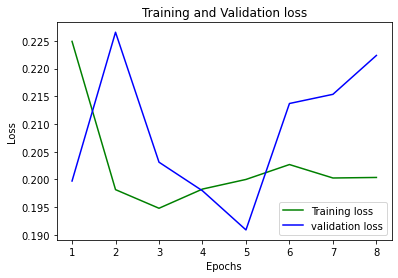

In [ ]:
loss_train = history3.history['loss']
loss_val = history3.history['val_loss']
epochs = len(loss_train)+1
plt.plot(np.arange(1,epochs), loss_train, 'g', label='Training loss')
plt.plot(np.arange(1,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

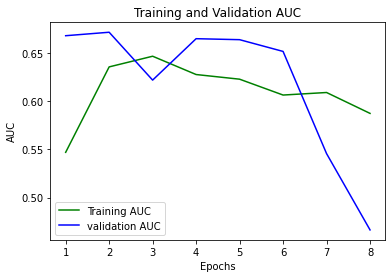

In [ ]:
AUC_train = history3.history['auc']
AUC_val = history3.history['val_auc']
epochs = len(AUC_train)+1
plt.plot(np.arange(1,epochs), AUC_train, 'g', label='Training AUC')
plt.plot(np.arange(1,epochs), AUC_val, 'b', label='validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# We got from this trial 3 with 128 Hidden Units 
- loss: 0.2004 
- auc: 0.5872 
- val_loss: 0.2224 
- val_auc: 0.4665
- According to graphs there is no overfitting happened .
- Noticed the Accuracy get decrease from previouse one .
- The Accuracy on kaggle ,  Score: 0.43816


# **Trial 4 -> Using 256 For hidden Units**

In [ ]:
model=GCNN(256) # here we call method with in 256 hidden units 

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # early stopping 
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history4=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=100,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[callback]
) # fit model 
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)# Predict
y_pred = np.reshape(y_pred, -1)

# Sample Submission CSV
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_Hidden_256.csv') # save results in csv 

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_7/Sigmoid:0', description="created by layer 'dense_7'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tens

1330/1330 [==============================] - 37s 25ms/step - loss: 0.2177 - auc: 0.5834 - val_loss: 0.1996 - val_auc: 0.6298
Epoch 2/100
1330/1330 [==============================] - 34s 25ms/step - loss: 0.2006 - auc: 0.6429 - val_loss: 0.1956 - val_auc: 0.6786
Epoch 3/100
1330/1330 [==============================] - 35s 26ms/step - loss: 0.1941 - auc: 0.6578 - val_loss: 0.1830 - val_auc: 0.7129
Epoch 4/100
1330/1330 [==============================] - 35s 26ms/step - loss: 0.1923 - auc: 0.6725 - val_loss: 0.1902 - val_auc: 0.6721
Epoch 5/100
1330/1330 [==============================] - 34s 25ms/step - loss: 0.1935 - auc: 0.6540 - val_loss: 0.1895 - val_auc: 0.6944
Epoch 6/100
1330/1330 [==============================] - 33s 25ms/step - loss: 0.1966 - auc: 0.6353 - val_loss: 0.1975 - val_auc: 0.6616


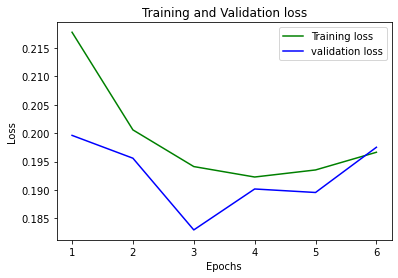

In [ ]:
loss_train = history4.history['loss']
loss_val = history4.history['val_loss']
epochs = len(loss_train)+1
plt.plot(np.arange(1,epochs), loss_train, 'g', label='Training loss')
plt.plot(np.arange(1,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

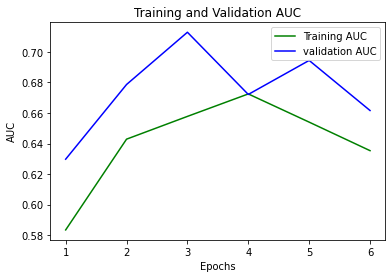

In [ ]:
AUC_train = history4.history['auc']
AUC_val = history4.history['val_auc']
epochs = len(AUC_train)+1
plt.plot(np.arange(1,epochs), AUC_train, 'g', label='Training AUC')
plt.plot(np.arange(1,epochs), AUC_val, 'b', label='validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# We got from this trial 4 with 256 hidden units 
- loss: 0.1966 
- auc: 0.6353 
- val_loss: 0.1975 
- val_auc: 0.6616
- According to graphs there is no overfitting happened and there is generalization here happend

- On kaggle we got Score: 0.67628 % 

# **we noticed from this trials (all previouse 4)**
while increase hidden units the accuracy decrease 
- The best one when hidden units 32 

# **Trial 5  message_passing mechanisms using ( GGNN ) with hidden units = ( 32 ) , the best value we got from the previouse experiment**

In [ ]:
# here we will use the best values of previouse experiment with GGNN
model=GCNN(32,"GGNN") # here we call method of GCNN wirh hidden units = 32 

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)# Compile model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # early stopping 
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history5=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=100,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[callback]
) # fit model
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

# Sample Submission CSV
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_Hidden_32_GGNN.csv') # save model in csv file 

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_8/StatefulPartitionedCall:0', description="created by layer 'gnn_8'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None,)]            0           []        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

1330/1330 [==============================] - 38s 26ms/step - loss: 0.1923 - auc: 0.6079 - val_loss: 0.1886 - val_auc: 0.6414
Epoch 2/100
1330/1330 [==============================] - 33s 25ms/step - loss: 0.1854 - auc: 0.6538 - val_loss: 0.1881 - val_auc: 0.6377
Epoch 3/100
1330/1330 [==============================] - 33s 25ms/step - loss: 0.1828 - auc: 0.6727 - val_loss: 0.1807 - val_auc: 0.6785
Epoch 4/100
1330/1330 [==============================] - 34s 25ms/step - loss: 0.1777 - auc: 0.7067 - val_loss: 0.1781 - val_auc: 0.6987
Epoch 5/100
1330/1330 [==============================] - 34s 25ms/step - loss: 0.1745 - auc: 0.7298 - val_loss: 0.1755 - val_auc: 0.7266
Epoch 6/100
1330/1330 [==============================] - 34s 26ms/step - loss: 0.1734 - auc: 0.7344 - val_loss: 0.1773 - val_auc: 0.7057
Epoch 7/100
1330/1330 [==============================] - 33s 25ms/step - loss: 0.1726 - auc: 0.7402 - val_loss: 0.1784 - val_auc: 0.7233
Epoch 8/100
1330/1330 [==============================

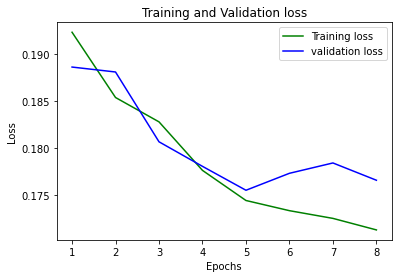

In [ ]:
loss_train = history5.history['loss']
loss_val = history5.history['val_loss']
epochs = len(loss_train)+1
plt.plot(np.arange(1,epochs), loss_train, 'g', label='Training loss')
plt.plot(np.arange(1,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

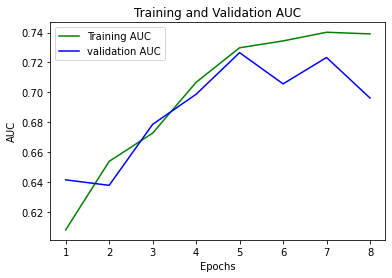

In [ ]:
AUC_train = history5.history['auc']
AUC_val = history5.history['val_auc']
epochs = len(AUC_train)+1
plt.plot(np.arange(1,epochs), AUC_train, 'g', label='Training AUC')
plt.plot(np.arange(1,epochs), AUC_val, 'b', label='validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# We got from this trial 5
- loss: 0.1713 
- auc: 0.7391 
- val_loss: 0.1766 
- val_auc: 0.6962
- According to graphs there is no overfitting happened 
- The Accuracy increased while using message_passing mechanisms using ( GGNN ) from the previouse experiment
- the accuracy on kaggle is Score: 0.74844


# **Trial 6  message_passing mechanisms (RGCN) with 32 hidden units ,that is the best Accuracy we got when hidden = 32**

In [ ]:
# here we use message passing RGCN with 32 hidden units 
model=GCNN(32,"RGCN")

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history6=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[callback]
)
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

# Sample Submission CSV
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_Hidden_32_RGCN.csv')# save model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_9/Sigmoid:0', description="created by layer 'dense_9'")
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None,)]            0           []        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

1330/1330 [==============================] - 52s 34ms/step - loss: 0.2222 - auc: 0.5154 - val_loss: 0.1961 - val_auc: 0.6237
Epoch 2/30
1330/1330 [==============================] - 31s 23ms/step - loss: 0.2001 - auc: 0.6027 - val_loss: 0.1995 - val_auc: 0.6140
Epoch 3/30
1330/1330 [==============================] - 27s 20ms/step - loss: 0.1914 - auc: 0.6464 - val_loss: 0.1997 - val_auc: 0.6630
Epoch 4/30
1330/1330 [==============================] - 27s 20ms/step - loss: 0.1861 - auc: 0.6843 - val_loss: 0.1814 - val_auc: 0.7031
Epoch 5/30
1330/1330 [==============================] - 27s 20ms/step - loss: 0.1844 - auc: 0.6915 - val_loss: 0.2110 - val_auc: 0.6793
Epoch 6/30
1330/1330 [==============================] - 26s 20ms/step - loss: 0.1833 - auc: 0.6948 - val_loss: 0.2065 - val_auc: 0.6738
Epoch 7/30
1330/1330 [==============================] - 31s 23ms/step - loss: 0.1844 - auc: 0.6934 - val_loss: 0.2181 - val_auc: 0.6266


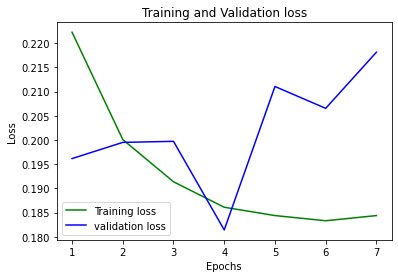

In [ ]:
loss_train = history6.history['loss']
loss_val = history6.history['val_loss']
epochs = len(loss_train)+1
plt.plot(np.arange(1,epochs), loss_train, 'g', label='Training loss')
plt.plot(np.arange(1,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

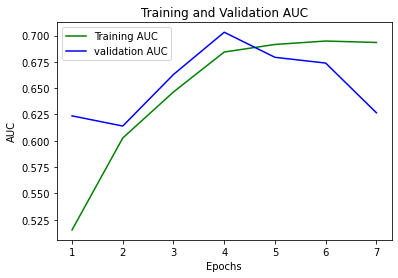

In [ ]:
AUC_train = history6.history['auc']
AUC_val = history6.history['val_auc']
epochs = len(AUC_train)+1
plt.plot(np.arange(1,epochs), AUC_train, 'g', label='Training AUC')
plt.plot(np.arange(1,epochs), AUC_val, 'b', label='validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# We got from this trial 6
- loss: 0.1844 
- auc: 0.6934 
- val_loss: 0.2181 
- val_auc: 0.6266
- According to graphs there is no overfitting happened .
- The Accuracy decreased according to the previouse one trial while using message_passing mechanisms using ( RGCN )
- the accuracy on kaggle is Score: 0.64611

# **Trial 7  message_passing mechanisms (RGAT) with 32 hidden units ,that is the best Accuracy we got when hidden = 32, using num_heads = 1**

In [ ]:
'''
here we will use 32 for hiddden units with Message Passing RGAT with num_heads = 1 
'''
model=GCNN(32,"RGAT",1)# call method 

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)# compile 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # early stopping 
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history7=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[callback]
) # fit model 
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

# Sample Submission CSV
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_Hidden_32_RGAT_1.csv') # save results in csv file 

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

1330/1330 [==============================] - 38s 22ms/step - loss: 0.2272 - auc: 0.4795 - val_loss: 0.2396 - val_auc: 0.6562
Epoch 2/30
1330/1330 [==============================] - 24s 18ms/step - loss: 0.1972 - auc: 0.5897 - val_loss: 0.2003 - val_auc: 0.6664
Epoch 3/30
1330/1330 [==============================] - 26s 20ms/step - loss: 0.1908 - auc: 0.6493 - val_loss: 0.2069 - val_auc: 0.6703
Epoch 4/30
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1881 - auc: 0.6695 - val_loss: 0.2043 - val_auc: 0.6766
Epoch 5/30
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1874 - auc: 0.6583 - val_loss: 0.1933 - val_auc: 0.7072
Epoch 6/30
1330/1330 [==============================] - 24s 18ms/step - loss: 0.1865 - auc: 0.6645 - val_loss: 0.1957 - val_auc: 0.7213
Epoch 7/30
1330/1330 [==============================] - 24s 18ms/step - loss: 0.1842 - auc: 0.6779 - val_loss: 0.2220 - val_auc: 0.7027
Epoch 8/30
1330/1330 [==============================] - 25s

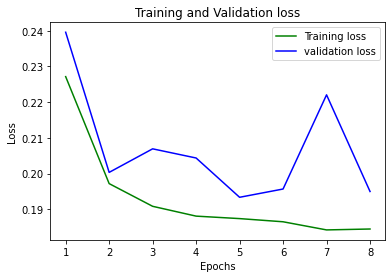

In [ ]:
'''
here we graph the loss and val_loss vs epochs 
'''
loss_train = history7.history['loss']
loss_val = history7.history['val_loss']
epochs = len(loss_train)+1
plt.plot(np.arange(1,epochs), loss_train, 'g', label='Training loss')
plt.plot(np.arange(1,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

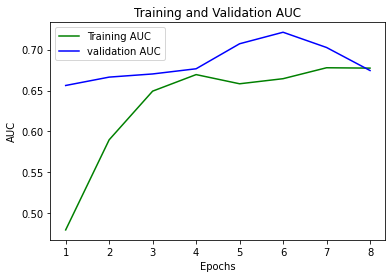

In [ ]:
'''
here we graph auc and val_Auc vs epochs 
'''
AUC_train = history7.history['auc']
AUC_val = history7.history['val_auc']
epochs = len(AUC_train)+1
plt.plot(np.arange(1,epochs), AUC_train, 'g', label='Training AUC')
plt.plot(np.arange(1,epochs), AUC_val, 'b', label='validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# We got from this trial 7
- loss: 0.1845 
- auc: 0.6774 
- val_loss: 0.1950 
- val_auc: 0.6745
- According to graphs there is no overfitting happened and there is generalization here happend
- Noticed the best one is ( GGNN ) , then the second best one is ( RGAT ) , then the third best one ( RGCN ) 
- Accuracy on kaggle is Score: 0.66838 %

# **Trial 8  message_passing mechanisms (RGAT) with 32 hidden units ,that is the best Accuracy we got when hidden = 32, using num_heads = 2**

In [ ]:
model=GCNN(32,"RGAT",2)# here using RGAT WITH 2 of heads 

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # early stopping 
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history8=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[callback]
) # fit model 
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
) # here predict 
y_pred = np.reshape(y_pred, -1)

# Sample Submission CSV
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_Hidden_32_RGAT_2.csv')

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgat_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memo

1330/1330 [==============================] - 36s 24ms/step - loss: 0.2188 - auc: 0.5081 - val_loss: 0.2082 - val_auc: 0.6330
Epoch 2/30
1330/1330 [==============================] - 37s 28ms/step - loss: 0.1910 - auc: 0.6295 - val_loss: 0.2098 - val_auc: 0.6729
Epoch 3/30
1330/1330 [==============================] - 39s 30ms/step - loss: 0.1883 - auc: 0.6632 - val_loss: 0.2063 - val_auc: 0.7037
Epoch 4/30
1330/1330 [==============================] - 26s 19ms/step - loss: 0.1857 - auc: 0.6711 - val_loss: 0.2091 - val_auc: 0.7286
Epoch 5/30
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1849 - auc: 0.6814 - val_loss: 0.1888 - val_auc: 0.7209
Epoch 6/30
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1824 - auc: 0.6902 - val_loss: 0.1915 - val_auc: 0.7251
Epoch 7/30
1330/1330 [==============================] - 28s 21ms/step - loss: 0.1823 - auc: 0.6940 - val_loss: 0.1945 - val_auc: 0.7277
Epoch 8/30
1330/1330 [==============================] - 27s

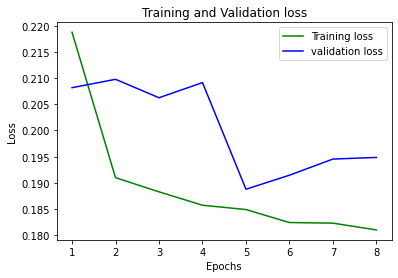

In [ ]:
loss_train = history8.history['loss']
loss_val = history8.history['val_loss']
epochs = len(loss_train)+1
plt.plot(np.arange(1,epochs), loss_train, 'g', label='Training loss')
plt.plot(np.arange(1,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

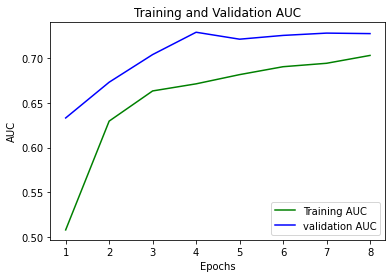

In [ ]:
AUC_train = history8.history['auc']
AUC_val = history8.history['val_auc']
epochs = len(AUC_train)+1
plt.plot(np.arange(1,epochs), AUC_train, 'g', label='Training AUC')
plt.plot(np.arange(1,epochs), AUC_val, 'b', label='validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# We got from this trial 8
- loss: 0.1810 
- auc: 0.7028 
- val_loss: 0.1949 
- val_auc: 0.7271
- According to graphs there is no overfitting happened 

- Noticed the Accuracy is increased on kaggle and on validation when change the number of heads to 2

- The accuracy on kaggle is 70 %

# **Here We will Apply UpSampling Using RandomOverSampler Method**

In [ ]:
'''
Here we will UpSampling to 
Upsampling is the process of inserting zero-valued samples between original samples to increase the sampling rate. 
'''

from collections import Counter
training_set = read_sdf('train.sdf') # Read sdf file (Training)
training_set=np.array(training_set)
input =  training_set[:,0:-1]
output = training_set[:,-1]
output = output.astype('float16')
print(output)
print(Counter(output))
oversample = RandomOverSampler(sampling_strategy='minority')

input,output = oversample.fit_resample(input,output)
output = output.reshape(len(output),1)
training_set = np.append(input, output, axis=1)
print(Counter(training_set[:,-1]))
'''
according to the counter the upsampling is applied here correctly on training data set
Counter({0.0: 23806, 1.0: 23806})
The Training data is balanced now the number of zero's equal to the number of one's
'''

  0%|          | 0/25024 [00:00<?, ?it/s]

[0. 0. 0. ... 0. 0. 0.]
Counter({0.0: 23806, 1.0: 1218})
Counter({0.0: 23806, 1.0: 23806})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


"\naccording to the counter the upsampling is applied here correctly on training data set\nCounter({0.0: 23806, 1.0: 23806})\nThe Training data is balanced now the number of zero's equal to the number of one's\n"

In [ ]:
training_set, validation_set = train_test_split(training_set, test_size=0.15,) # Split training data into training and validation 


In [ ]:
!pip install --quiet networkx
colors = cm.rainbow(np.linspace(0, 1, 50)) # Colors 

In [ ]:
'''
  Visualization Method

'''
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

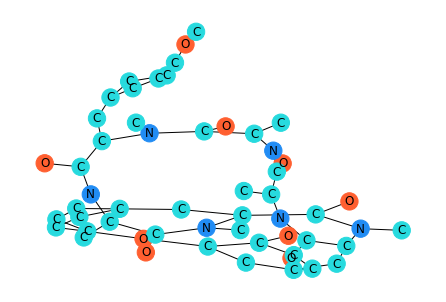

In [ ]:
plt.clf()
visualize(training_set[20]) # Visulization Of Graph 

In [ ]:
max_vocab = 500 # Max Vocab
max_len = 100 # Max Length 


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # All Nodes 
tokenizer = Tokenizer(num_words=max_vocab) # Tokenizer  
tokenizer.fit_on_texts(all_nodes) #this method creates the vocabulary index based on word frequency.
#all_nodes
#print(all_nodes)
#print(tokenizer.word_index)

In [ ]:
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post') # padding each one 
    '''
       texts_to_sequences -> Transforms each text in texts to a sequence of integers. 
    So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
    Nothing more, nothing less, certainly no magic involved
    '''
    max_nodes_len = np.shape(sample_nodes)[1] # number of nodes in each sample
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0] # make sure all nodes are non zero
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)    # Concatenate nodes of all samples together
    all_edges = np.concatenate(edges)  # Concatenate edges of all samples together

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
print(training_set[0])
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

[list(['Cl', 'O', 'O', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'])
 array([[ 0, 20],
        [ 1, 10],
        [ 2, 26],
        [ 2, 28],
        [ 3,  7],
        [ 3, 10],
        [ 3, 12],
        [ 4, 14],
        [ 4, 17],
        [ 5, 15],
        [ 6,  7],
        [ 6,  8],
        [ 6,  9],
        [ 7, 13],
        [ 8, 11],
        [ 8, 19],
        [ 9, 12],
        [ 9, 20],
        [10, 14],
        [11, 15],
        [11, 21],
        [13, 15],
        [14, 18],
        [16, 17],
        [16, 18],
        [16, 22],
        [17, 23],
        [19, 24],
        [21, 25],
        [22, 26],
        [23, 27],
        [24, 25],
        [26, 27]]) 1.0]
data
[ 4  4  4  4  4  4  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 

# **Trial 9 -> Using 32 For hidden Units using OverSampling Method**

In [ ]:
'''
Hidden Units 32 with using OverSampling method 
'''
model=GCNN(32)

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)# compile 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)# early stopping 

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history9=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=100,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
     callbacks=[callback]
) # fit model
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
) # predict 
y_pred = np.reshape(y_pred, -1)

# Sample Submission CSV
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('upSample_32.csv') # save data in csv

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

2530/2530 [==============================] - 47s 17ms/step - loss: 0.6276 - auc: 0.7035 - val_loss: 0.6115 - val_auc: 0.7265
Epoch 2/100
2530/2530 [==============================] - 44s 18ms/step - loss: 0.5939 - auc: 0.7490 - val_loss: 0.5983 - val_auc: 0.7526
Epoch 3/100
2530/2530 [==============================] - 44s 17ms/step - loss: 0.5826 - auc: 0.7626 - val_loss: 0.5812 - val_auc: 0.7710
Epoch 4/100
2530/2530 [==============================] - 44s 17ms/step - loss: 0.5737 - auc: 0.7738 - val_loss: 0.5702 - val_auc: 0.7816
Epoch 5/100
2530/2530 [==============================] - 45s 18ms/step - loss: 0.5604 - auc: 0.7864 - val_loss: 0.5458 - val_auc: 0.8056
Epoch 6/100
2530/2530 [==============================] - 44s 17ms/step - loss: 0.5479 - auc: 0.7983 - val_loss: 0.5446 - val_auc: 0.8056
Epoch 7/100
2530/2530 [==============================] - 64s 25ms/step - loss: 0.5392 - auc: 0.8061 - val_loss: 0.5357 - val_auc: 0.8152
Epoch 8/100
2530/2530 [==============================

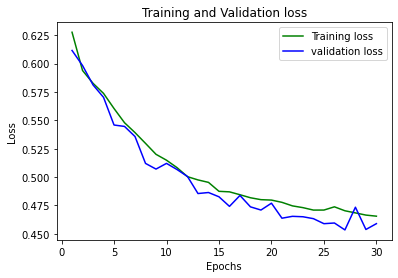

In [ ]:
'''
graph loss and val_loss vs epochs
'''
loss_train = history9.history['loss']
loss_val = history9.history['val_loss']
epochs = len(loss_train)+1
plt.plot(np.arange(1,epochs), loss_train, 'g', label='Training loss')
plt.plot(np.arange(1,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

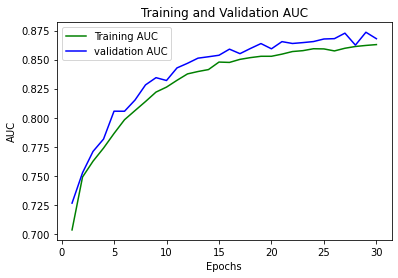

In [ ]:
'''
graph auc and val_auc vs epochs
'''
AUC_train = history9.history['auc']
AUC_val = history9.history['val_auc']
epochs = len(AUC_train)+1
plt.plot(np.arange(1,epochs), AUC_train, 'g', label='Training AUC')
plt.plot(np.arange(1,epochs), AUC_val, 'b', label='validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# We got from this trial 9
- loss: 0.4655 
- auc: 0.8629 
- val_loss: 0.4589 
- val_auc: 0.8680

- According to graphs there is no overfitting happened and generalization happend here

- Noticed the Accuracy is Improved on kaggle and on validation when using Up sampleing Method 

- On kaggle we got 83 %

# **Trial 10 -> Using 32 For hidden Units using OverSampling Method with  message_passing mechanisms (GGNN)**

In [ ]:
'''
Hidden Units 32 with using OverSampling method with message_passing mechanisms (GGNN)
'''
model=GCNN(32,"GGNN")

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)# compile 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)# early stopping 

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history10=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=100,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
     callbacks=[callback]
) # fit model
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
) # predict 
y_pred = np.reshape(y_pred, -1)

# Sample Submission CSV
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('upSample_32_GGNN.csv') # save data in csv

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

2530/2530 [==============================] - 85s 31ms/step - loss: 0.6258 - auc: 0.6999 - val_loss: 0.5933 - val_auc: 0.7529
Epoch 2/100
2530/2530 [==============================] - 71s 28ms/step - loss: 0.5672 - auc: 0.7767 - val_loss: 0.5280 - val_auc: 0.8189
Epoch 3/100
2530/2530 [==============================] - 72s 28ms/step - loss: 0.5223 - auc: 0.8192 - val_loss: 0.5076 - val_auc: 0.8438
Epoch 4/100
2530/2530 [==============================] - 70s 28ms/step - loss: 0.4896 - auc: 0.8446 - val_loss: 0.4711 - val_auc: 0.8606
Epoch 5/100
2530/2530 [==============================] - 71s 28ms/step - loss: 0.4597 - auc: 0.8652 - val_loss: 0.4419 - val_auc: 0.8810
Epoch 6/100
2530/2530 [==============================] - 71s 28ms/step - loss: 0.4357 - auc: 0.8801 - val_loss: 0.4343 - val_auc: 0.8872
Epoch 7/100
2530/2530 [==============================] - 71s 28ms/step - loss: 0.4148 - auc: 0.8920 - val_loss: 0.4006 - val_auc: 0.9014
Epoch 8/100
2530/2530 [==============================

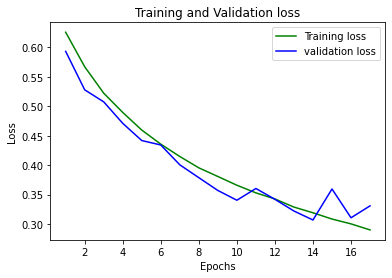

In [ ]:
'''
graph loss and val_loss vs epochs
'''
loss_train = history10.history['loss']
loss_val = history10.history['val_loss']
epochs = len(loss_train)+1
plt.plot(np.arange(1,epochs), loss_train, 'g', label='Training loss')
plt.plot(np.arange(1,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

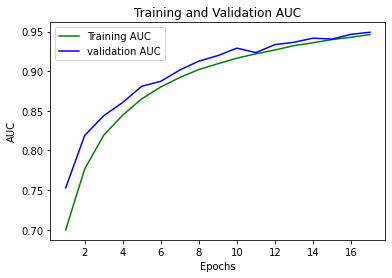

In [ ]:
'''
graph auc and val_auc vs epochs
'''
AUC_train = history10.history['auc']
AUC_val = history10.history['val_auc']
epochs = len(AUC_train)+1
plt.plot(np.arange(1,epochs), AUC_train, 'g', label='Training AUC')
plt.plot(np.arange(1,epochs), AUC_val, 'b', label='validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# We got from this trial 10
- loss: 0.2901 
- auc: 0.9461 
- val_loss: 0.3309 
- val_auc: 0.9491

- According to graphs there is no overfitting happened and generalization happend here

- Noticed the Accuracy is Improved on kaggle and on validation when using Up sampleing Method with GGNN

- On kaggle we got 87 %

# **From all these trials i see the upsampling make a huge difference in accuracy**

# ✔️ Answer the questions below (briefly):



# 🌈Based on the provided template, describe the format of the input file (sdf file).

  1 - Each sample contain dollar sign to read sample by sample .

  2 - Label for each sample -1 or 1 

  3 - Nodes label like ( S,O,N,C,...... ETC)

  4 - From and To of graph using the labels 

  5 - All this is representation of graph 

  6- The foramt of the file is sdf

  7- It contains information about the chemical composition of a molecule.
  
  8- Different molecules are delimited by '$$$$' expression


# 🌈What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

#**1 - Data**
-> The nodes of the chemical compound 

-> Tokenized using the tokenizer and finally padding is done using pad_sequence method

->The shape for each batch is [batch_size*max_len_nodes]

* batch_size is the number of samples in the batch 

* max_len_nodes is the length of tokenized nodes after padding is done.

**************************************
#**2 - Edge**
->  The input tensor which carries information about connections between atoms

-> The shape of edge is [sum_of_edges,2].

* The sum_of_edges :- represents the sum of edges of each sample of the batch_size
*******************************
#**3 -node2graph**

-> It is the input tensor which is used for segmented mean and contains information about segmented ids

-> The Shape for each batch is [batch_size*max_len_nodes]


# 🌈For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

gnn_out:-

 -> The shape is [batch_size_dimension,hidden layers] .
 * batch_size_dimension is the dimension of the input data (node) vector (dimension of tokenized vector for the complete batch). It is the output of the model for each hidden layer.

**************************************
avg:-

* Takes the segmented mean of the gnn_out based on the segmented ids. 
For each sample in the batch_size, the output of gnn_out is [tokenized_vector_dimension, hidden_layers].

* Each sample has one segment id. the segment_mean takes the mean of all the output data in the gnn_out output and represents one sample with one number for each hidden layer. The final output of the avg tensor is of shape [batch_size, hidden_layer]. It is collecting information for each sample and representing it in the form of mean data

# 🌈What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

1- Segment_mean :- The mean of the data which have same segmented ids.

2- Reduce_mean():- is used to find mean of elements across dimensions of a tensor. Syntax: tensorflow.math.reduce_mean( input_tensor, axis, keepdims, name) Parameters: input_tensor: It is numeric tensor to reduce

--------------------------------------------

pred: The prediction of output tells about the probability of a chemical compound to be active for the cancer cell or not (0 or 1 ). 

# **->The shape of prediction is [batch_size,1].**

#🌈What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?


-> Using multiple gcn helps in incorporating all the graph complexity properly and creates a better model.

-> The number of layers are = 4 and more 